### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [44]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
import time

# MRS Load in the data
data = np.load('../../../homeworks/hw_data/hw6_data_1.npy')

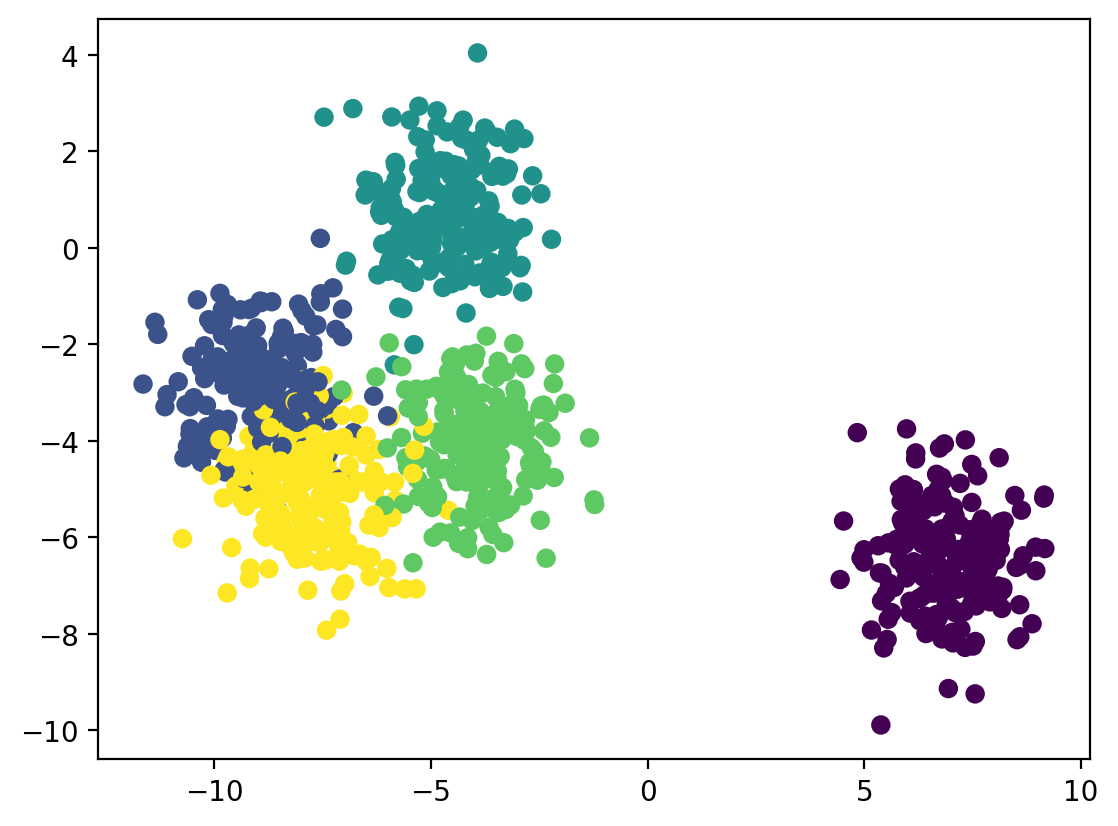

In [53]:
# MRS Plot the features colored by their labels
plt.scatter(data[:,0], data[:, 1], c= data[:, 2])

plt.show()

Optimal Bandwidth: 0.472


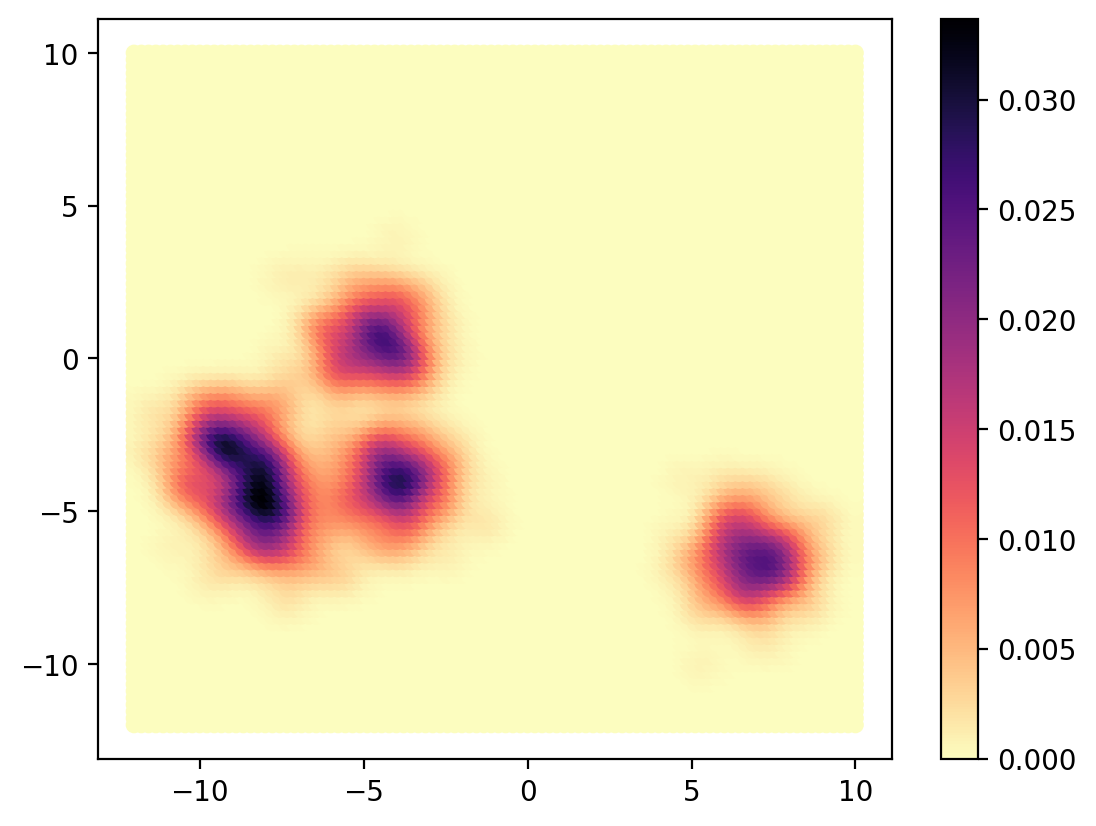

In [46]:
# MRS Borrowed code from Lecture 14

# MRS Initialize the KernelDensity Package
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.1, 1.0, 30) # MRS Testing 30 bandwidths from 0.1 to 1.0
K = 5 # MRS Number K-fold cross-validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:, :2]) #  MRS Fit data imported in beginning.
h_opt = grid.best_params_['bandwidth']

# MRS Print the optimal bandwidth
print(f'Optimal Bandwidth: {h_opt:.3f}')


# MRS Do the kernel density estimation of the data using the optimal bandwidth 
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data[:, :2]) #fit the model to the data

# MRS Initializing a grid to plot the 2d kernel density estimation
u = v = np.linspace(-12,10,100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="magma_r", edgecolor="None")
plt.colorbar()

SRT: Great colorscheme.

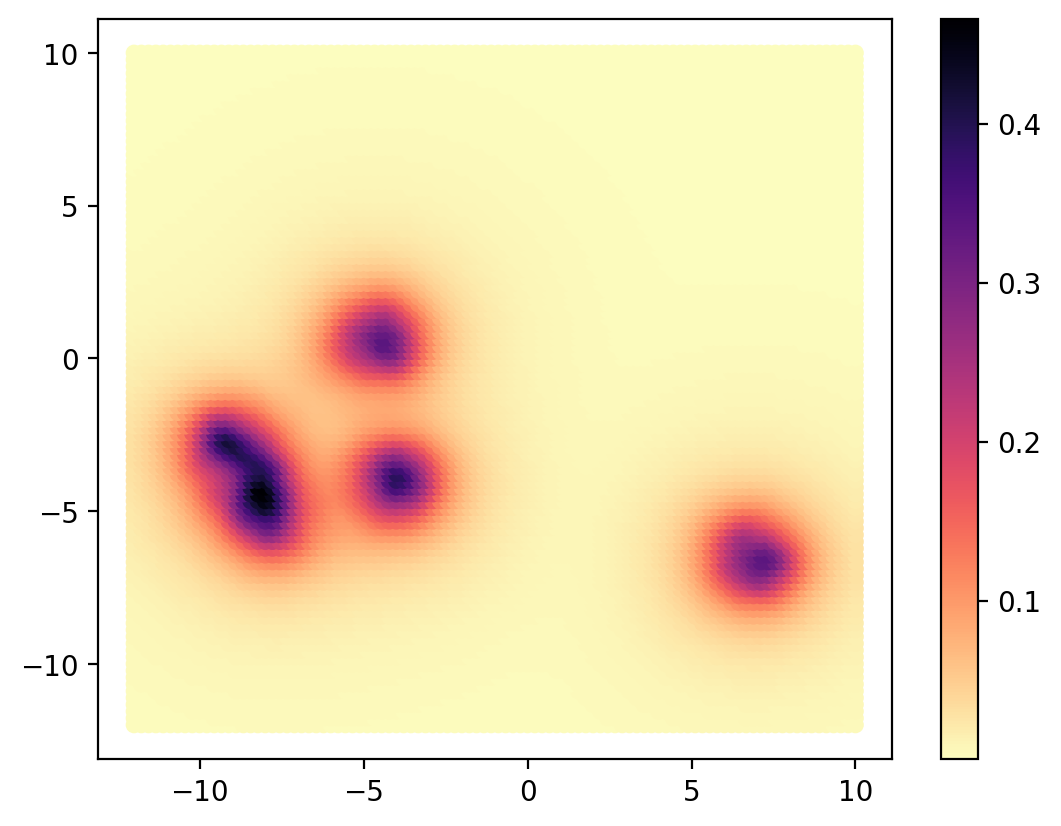

In [47]:
# MRS Again borrowing and adapting some code from Lecture 14

# MRS Initializing Nearest Neighbors package
from astroML.density_estimation import KNeighborsDensity

# MRS Played around with a number of different k values
k = 80 #Number of neighbors
# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, :2])

# MRS Again initialize a 2D grid for visualizeing nearest neighbors estimation
u = v = np.linspace(-12,10,100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T

# MRS evaluate on the xgrid
vals = nbrs.eval(Xgrid) / 80
vals = vals.reshape(100, 100)  

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=vals, 
            cmap="magma_r", edgecolor="None")

plt.colorbar()
plt.show()

# K = 80 seems to look like the KDE 



SRT: Sure does.

In [48]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

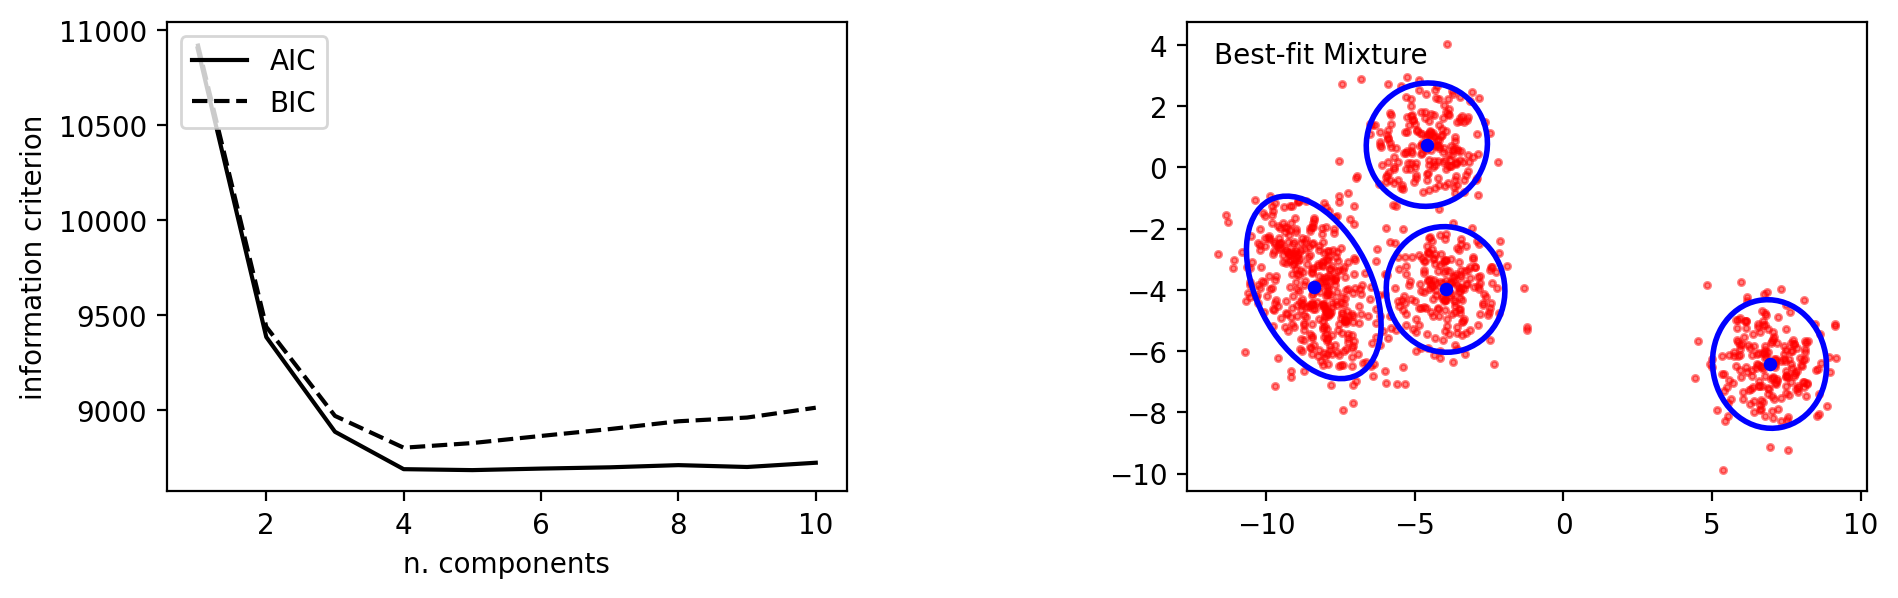

In [49]:
# MRS importing package for GMM 
# MRS Using code from Lecture 14
from sklearn.mixture import GaussianMixture

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(data[:, :2])

# compute the AIC and the BIC
AIC = [m.aic(data[:, :2]) for m in models]
BIC = [m.bic(data[:, :2]) for m in models]

fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)

# plot 1: AIC and BIC
ax = fig.add_subplot(121)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# MRS Fitting the data with the optimal number of GMM components from the BIC
ax = fig.add_subplot(122)
M_best = N[np.argmin(BIC)]

# MRS Fit data with best fit number of components
best_fit = GaussianMixture(M_best).fit(data[:, :2])

# MRS Store the means and the covariances for plotting the cluster means as well as the 2-sigma GMM component ellipses
best_fit_means = best_fit.means_
best_fit_covs = best_fit.covariances_

# MRS Plotting the data and the best fit cluster means
ax.scatter(data[:, 0], data[:, 1], c='red', s=5, alpha=0.5)
ax.scatter(best_fit_means[:, 0], best_fit_means[:, 1], c='blue', s=15, alpha=1)

# MRS Drawing the 2-sigma GMM component ellipses
for i in range(0, len(best_fit_covs)):
    draw_ellipse(best_fit_means[i], best_fit_covs[i], scales=[2], ax=ax, edgecolor='blue', facecolor='none', lw=2)

ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)


plt.show()

SRT: Awesome

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [50]:
# MRS Now using the Kmeans Clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing

# Compute the KMeans clustering
n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(data[:, :2]))

KMeans(n_clusters=5)

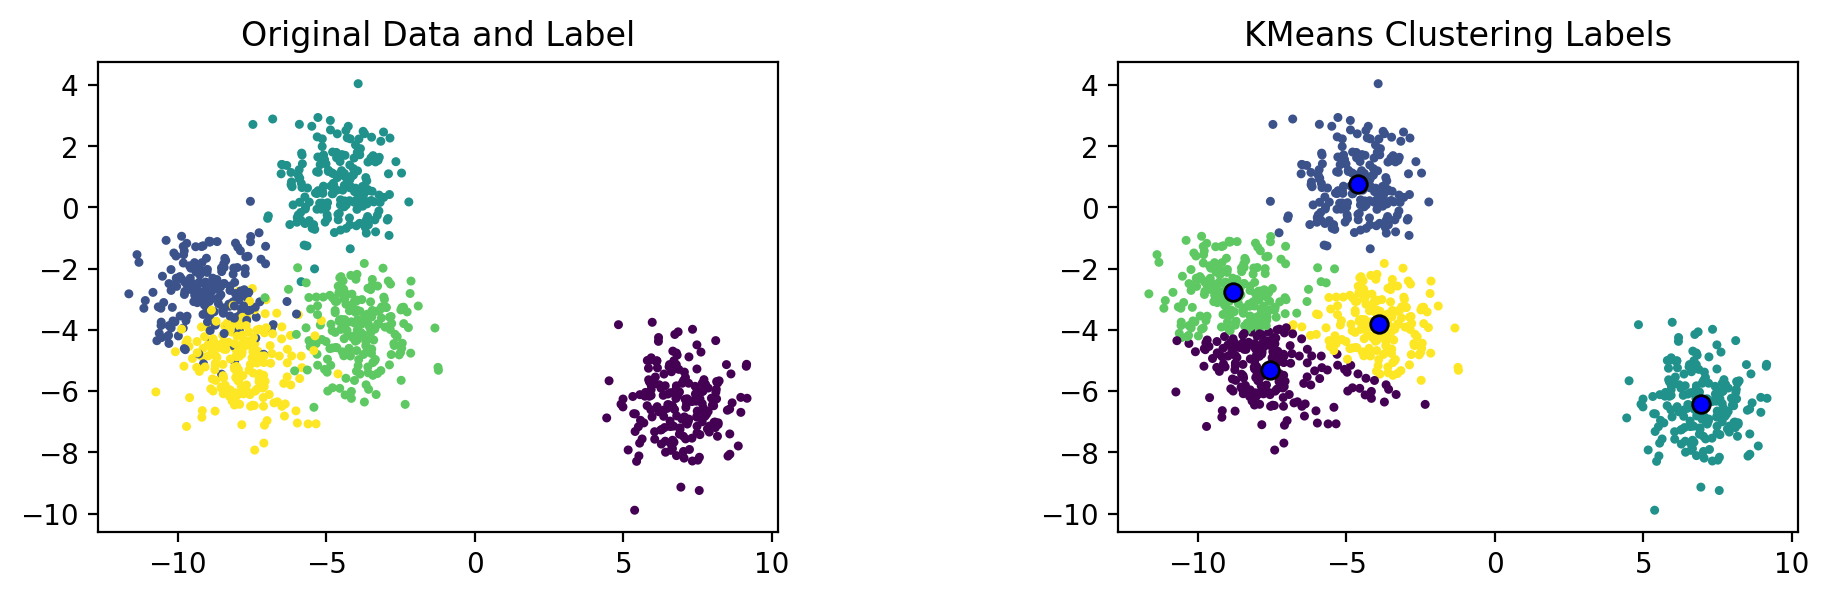

In [51]:
fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# MRS Plotting the original data with the original labels
ax = fig.add_subplot(121)
ax.scatter(data[:, 0], data[:, 1], c=data[:, 2], s=5, alpha=1)
ax.set_title('Original Data and Label')

# MRS Plotting data with predicted labels and cluster means
ax = fig.add_subplot(122)

# MRS Store predicted labels for coloring
predicted_labels = clf.labels_

# MRS plot the data colored by predicted labels
ax.scatter(data[:, 0], data[:, 1], c=predicted_labels, s=5, alpha=1)

# MRS  perform the inverse transform on the cluster centers for plotting
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='b', edgecolors='k')
ax.set_title('KMeans Clustering Labels')
plt.show()



SRT: Perfect, Mike.

50/50